# Gaussian Processes

This notebook serves as a simple tutorial for Gaussian Processes. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

### Introduction

Lets assume we have $n$ samples and a feature with $m$ features per sample. In our simple case $m=1$. To be able to fit non linear functions we transform our features using $\phi(x)$. The model we would then like to fit to the data ist the following:

$$f(x) = \Sigma_{i=1}^d w_i \ \phi_i(x)$$

We might use $\phi(x) = [1, x, x^2]$ to be able to fit functions of degree 2.

The core idea of gaussian processes is to reason about function predictions instead of model parameters. We assume, that the weights of our model are normally distrubuted: 

$$W = [w_1, ..., w_d]^T \text{ ~ } \mathcal{N}(0, I)$$



We consider a an arbitrary set of $n$ inputs and denote $X$ as the matrix containing our transformed features.  

$$X = \begin{bmatrix}
     - \  \phi(x_{1}) \ - \\
    .. \\
    - \  \phi(x_{n}) \ - \\
\end{bmatrix} 
\quad 
\in R^{n \times d}
\quad
$$



We introduce the random variable $f = [f_1, f_2,..,f_n]$ describing our function responses, where $f_i = x_i^Tw$ and thus $f = Xw$.

$$f \text{ ~ }\mathcal{N}(0, XX^T)$$








Assuming that our error term is distributed via  $\epsilon \text{ ~ } \mathcal{N}(0, \sigma^2 I)$ our prior distribution of labels is:

$$y \text{ ~ } \mathcal{N}(0, XX^T + \sigma^2 I) \ \ \text{ as } \ \ y = f + \epsilon$$

This represents our prior belief of how our observations are distributed. Without having observed any labels $y$ of the input data we can sample from this distribution.

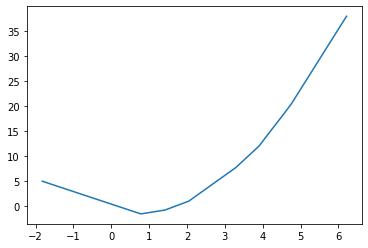

In [26]:
x_obs = np.random.uniform(-2, 8, 10)
x_obs.sort()
X = np.matrix([[1,x, x**2] for x in x_obs])
sigma = 0.2

XX_T = np.matmul(X, X.T)
sample = np.random.multivariate_normal(np.repeat(0,10), XX_T + sigma**2 * np.eye(10))

plt.plot(x_obs, sample)

We have now described the our a priori belief of how the function looks like and we can sample from this distribution. However looking at the sample we see that it either explodes to $+\infty$ or $-\infty$ depending if the weight for the $x^2$ component is positive or negative. This is a known effect called the Runge Effect that appears when working with polinomials to interpolate functions.

<Axes: >

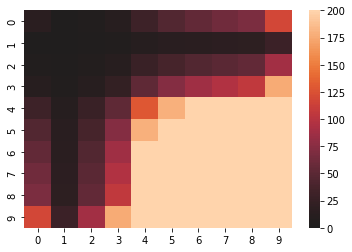

In [36]:
sns.heatmap(XX_T, annot=False, vmin=0, vmax=200, center=0)

Looking at the covariance matrix of our prior distribution of $y$ we see a problem. Simply put, the covariance matrix does not make much sense. We have a high covaraince between $y_9$ and all other labels while the covariance between $y_0$ and $y_1$ is very small even though they are much closer together. In the next section we look at how we can change this covaraince matrix.

### The Kernel Trick

I did not have time yet to explain this properly

If we look at the distribution of a single function response, we get

$$f_i \text{ ~ }\mathcal{N}(0, \phi(x_i)^T\phi(x_i))$$

We kernalize $K_{X,X'} = \phi(X)^T\phi(X') = k(X,X')$

$f$ ~$\mathcal{N}(0, K_{X,X})$

$\tilde{y}$ ~ $\mathcal{N}(0, K_{X,X} + \sigma^2 I)$

In [31]:
def k(xs, ys, sigma=1, l=0.3):
    """
    RBF kernel function to compute the covariance matrix between xs and ys.
    
    Args:
    xs (np.array): First set of input vectors (n x d)
    ys (np.array): Second set of input vectors (m x d)
    sigma (float): Signal variance (amplitude) parameter
    l (float): Length scale parameter
    
    Returns:
    np.array: Covariance matrix (n x m)
    """
    # Compute pairwise squared Euclidean distances
    xs_expanded = np.expand_dims(xs, 1)  # Shape: (n, 1, d)
    ys_expanded = np.expand_dims(ys, 0)  # Shape: (1, m, d)
    squared_distances = np.sum((xs_expanded - ys_expanded)**2, axis=2)
    
    # Compute the RBF kernel
    covariance_matrix = sigma**2 * np.exp(-0.5 * squared_distances / l**2)
    
    return covariance_matrix

In [39]:
l = np.matrix(np.linspace(-2, 8, 20)).T
cov_matrix = k(l,l, sigma=1, l=1)

<Axes: >

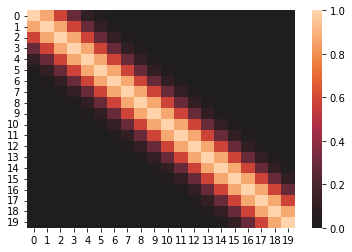

In [40]:
sns.heatmap(cov_matrix, annot=False, vmin=0, vmax=1, center=0)

### Making Predictions

Now lets assume we have made $n$ oversevations with and now want to make a prediction at $x^*$. We have:

$$\tilde{X} = \begin{pmatrix}
X \\
- \\
x^*
\end{pmatrix}, 
\quad
\tilde{y} = \begin{pmatrix}
y \\
- \\
y^*
\end{pmatrix}
\quad
\tilde{F} = \begin{pmatrix}
F \\
- \\
f^*
\end{pmatrix}
$$

As discussed before our priori distribution of labels:

$$\tilde{y} \text{ ~ } \mathcal{N}(0, K(X,X) + \sigma^2 I)$$

We are interested in the a postiori distribution:

$$p(y^*| y, \tilde{X})$$

We can achieve this using Bayes Rule:

$$p(y^* | y, \tilde{X})
=
\frac{p(y| y^*, \tilde{X}) p(y^* | \tilde{X}) }{p(y \ | \ X)}
=
\frac{p(\tilde{y}  \ | \ \tilde{X})}{p(y \ | \ X)}$$

$$= \frac{\mathcal{N}(\tilde{y};\ 0, K(\tilde{X},\tilde{X}) + \sigma^2 I)}{\mathcal{N}(y;\ 0, K(X,X) + \sigma^2 I)}$$

$$ = \mathcal{N}(y^*; \ \mu^*, \ \sigma^*)$$


$$\mu^* = K(x^*, X) (K(X,X) + \sigma^2I)^{-1} y$$


$$\Sigma^* = (K(x^*, x^*) + \sigma^2 I) - K(x^*, X) (K(X,X) + \sigma^2 I)^{-1} K(X, x^*)$$

###  Implementation

In [41]:
sample_func = lambda x : (np.sin(x*2)*2)

In [42]:
def plot_samples(x_values, y_values, x_s=[], mu_s=[], std_s=[]):
    
    plt.scatter(x_values, y_values, color='red')
    if len(x_s) > 0:
        plt.plot(x_s, mu_s)
        plt.fill_between(x_s, mu_s - std_s, mu_s + std_s, alpha=0.2)

    plt.ylim(bottom=-3, top=3)
    plt.show()

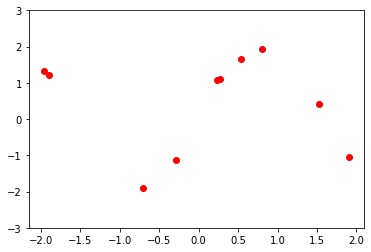

In [43]:
a, b = -2, 2
n = 10
sigma = 0.1

x_obs = np.random.uniform(a, b, n)
y_obs = np.array([sample_func(x) + np.random.normal(0, sigma) for x in x_obs])

# Call the function
plot_samples(x_obs, y_obs)

In [44]:
X = np.matrix(x_obs).T
Y = np.matrix(y_obs).T
x_s = np.matrix(np.linspace(a-1, b+1, 100)).T

In [45]:
K = k(X,X)
K_s = k(X, x_s)
K_ss = k(x_s, x_s)

In [46]:
K_sTKinv = np.matmul(K_s.T, np.linalg.inv(K + sigma**2 * np.eye(n)))
mu_s = np.matmul(K_sTKinv, Y)
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)
std_s = Sigma_s.diagonal() ** (1/2)

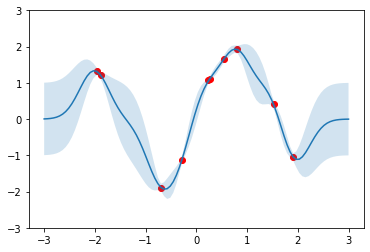

In [47]:
plot_samples(x_obs, y_obs, np.array(x_s.T)[0], np.array(mu_s.T)[0], std_s)

#### Drawing function samples from the distribution

In [48]:
def plot_function_samples(x_values, y_values, num_samples=0, x_s=[], mu_s=[], Sigma_s=[]):
    
    plt.scatter(x_values, y_values, color='red')
    
    for i in range(num_samples):
        sample = np.random.multivariate_normal(mu_s, Sigma_s)
        plt.plot(x_s, sample)

    plt.ylim(bottom=-3, top=3)
    plt.show()

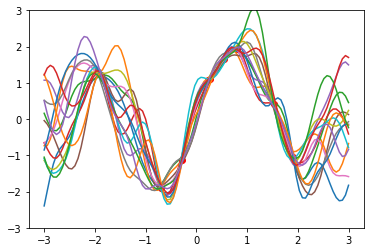

In [49]:
plot_function_samples(x_obs, y_obs, 15, np.array(x_s.T)[0], np.array(mu_s.T)[0], Sigma_s)